<a href="https://colab.research.google.com/github/CoderAPS/HuBMAP/blob/main/HuBMAP_normalize_H%26E_stained_images_20230606.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
#!/usr/bin/env python
__license__ = "Feel free to copy, I appreciate if you acknowledge Python for Microscopists"
# https://youtu.be/yUrwEYgZUsA
"""
This code normalizes staining appearance of H&E stained images.
It also separates the hematoxylin and eosing stains in to different images. 

Workflow based on the following papers:
A method for normalizing histology slides for quantitative analysis. 
M. Macenko et al., ISBI 2009
    http://wwwx.cs.unc.edu/~mn/sites/default/files/macenko2009.pdf

Efficient nucleus detector in histopathology images. J.P. Vink et al., J Microscopy, 2013

Original MATLAB code:
    https://github.com/mitkovetta/staining-normalization/blob/master/normalizeStaining.m
 
Other useful references:
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5226799/
    https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0169875

PROPOSED WORKFLOW:  
    
Input: RGB image
Step 1: Convert RGB to OD
Step 2: Remove data with OD intensity less than β
Step 3: Calculate  singular value decomposition (SVD) on the OD tuples
Step 4: Create plane from the SVD directions corresponding to the
two largest singular values
Step 5: Project data onto the plane, and normalize to unit length
Step 6: Calculate angle of each point wrt the first SVD direction
Step 7: Find robust extremes (αth and (100−α)th 7 percentiles) of the
angle
Step 8: Convert extreme values back to OD space

Output: Optimal Stain Vectors

"""


'\nThis code normalizes staining appearance of H&E stained images.\nIt also separates the hematoxylin and eosing stains in to different images. \n\nWorkflow based on the following papers:\nA method for normalizing histology slides for quantitative analysis. \nM. Macenko et al., ISBI 2009\n    http://wwwx.cs.unc.edu/~mn/sites/default/files/macenko2009.pdf\n\nEfficient nucleus detector in histopathology images. J.P. Vink et al., J Microscopy, 2013\n\nOriginal MATLAB code:\n    https://github.com/mitkovetta/staining-normalization/blob/master/normalizeStaining.m\n \nOther useful references:\n    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5226799/\n    https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0169875\n\nPROPOSED WORKFLOW:  \n    \nInput: RGB image\nStep 1: Convert RGB to OD\nStep 2: Remove data with OD intensity less than β\nStep 3: Calculate  singular value decomposition (SVD) on the OD tuples\nStep 4: Create plane from the SVD directions corresponding to the\ntw

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt


In [41]:
!ls /gdrive/MyDrive/DATA/HuBMAP/

annotation_count.csv  polygons.jsonl	     tile_meta.csv
masks		      sample_submission.csv  train
masks_4d	      test		     wsi_meta.csv


In [14]:
file_path = '/gdrive/MyDrive/DATA/HuBMAP/'
annotation_count = pd.read_csv(file_path + 'annotation_count.csv',index_col=0)
annotation_count.head()

,blood_vessel,glomerulus,unsure
0006ff2aa7cd,8,1,0
00168d1b7522,1,1,0
0033bbc76b6b,3,0,1
003504460b3a,7,0,0
004daf1cbe75,9,1,0


In [47]:
############### INPUT RGB IMAGE #######################
#Using opencv to read images may be more robust compared to using skimage
#but need to remember to convert BGR to RGB.
#Also, convert to float later on and normalize to between 0 and 1.

#Image downloaded from:
#https://pbs.twimg.com/media/C1MkrgQWQAASbdz.jpg
original_img = cv2.imread(file_path + 'train/0006ff2aa7cd.tif', 1)
img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
img_copy = img.copy()

Io = 240 # Transmitted light intensity, Normalizing factor for image intensities
alpha = 1  #As recommend in the paper. tolerance for the pseudo-min and pseudo-max (default: 1)
beta = 0.15 #As recommended in the paper. OD threshold for transparent pixels (default: 0.15)

In [29]:
img.shape

(512, 512, 3)

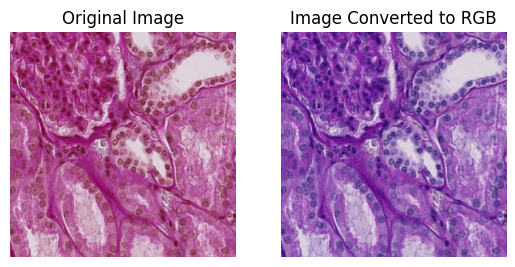

In [48]:
image_titles = ['Original Image','Image Converted to RGB']
images = [original_img,img_copy]

for idx, title in enumerate(image_titles):
  plt.subplot(1,2,idx+1)
  plt.imshow(images[idx])
  plt.title(image_titles[idx])
  plt.axis('off')

In [31]:
######## Step 1: Convert RGB to OD ###################
## reference H&E OD matrix.
#Can be updated if you know the best values for your image. 
#Otherwise use the following default values. 
#Read the above referenced papers on this topic. 
HERef = np.array([[0.5626, 0.2159],
                  [0.7201, 0.8012],
                  [0.4062, 0.5581]])
### reference maximum stain concentrations for H&E
maxCRef = np.array([1.9705, 1.0308])


# extract the height, width and num of channels of image
h, w, c = img.shape

# reshape image to multiple rows and 3 columns.
#Num of rows depends on the image size (wxh)
img = img.reshape((-1,3))
print(f'img shape: {img.shape}')

# calculate optical density
# OD = −log10(I)  
#OD = -np.log10(img+0.004)  #Use this when reading images with skimage
#Adding 0.004 just to avoid log of zero. 

#Add 1 in case any pixels in the image have a value of 0 (log 0 is indeterminate)
OD = -np.log10((img.astype(float)+1)/Io) #Use this for opencv imread

img shape: (262144, 3)


In [32]:
img[0]

array([156, 103, 173], dtype=uint8)

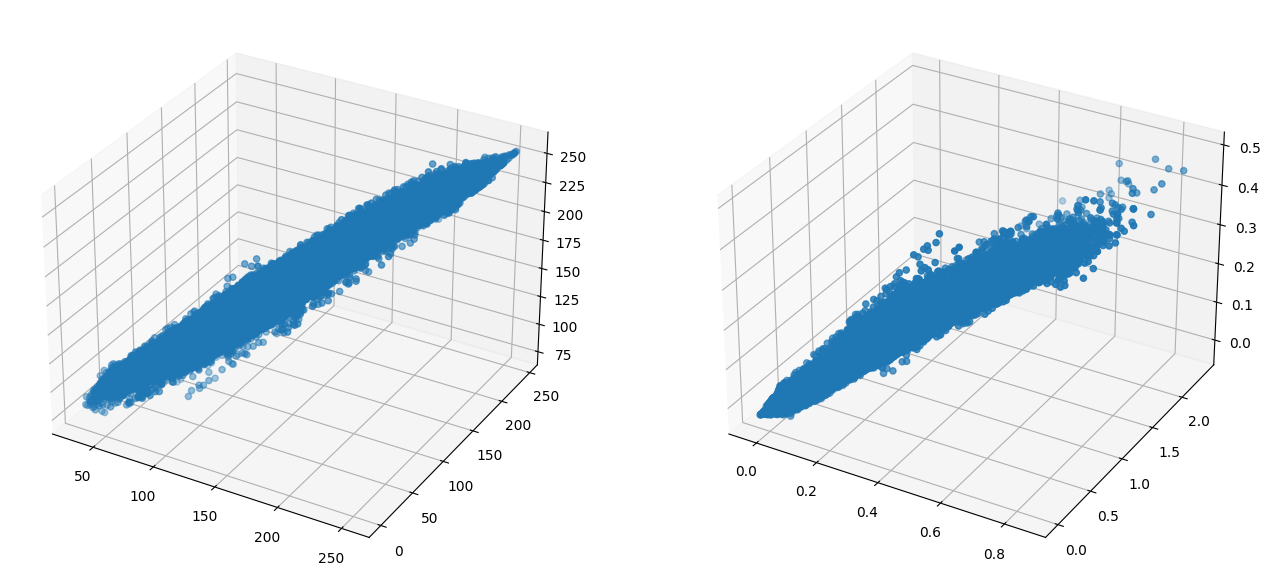

In [33]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(img[:,0],img[:,1],img[:,2])
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(OD[:,0],OD[:,1],OD[:,2])

plt.show()


In [34]:
############ Step 2: Remove data with OD intensity less than β ############
# remove transparent pixels (clear region with no tissue)
ODhat = OD[~np.any(OD < beta, axis=1)] #Returns an array where OD values are above beta
#Check by printing ODhat.min()

############# Step 3: Calculate SVD on the OD tuples ######################
#Estimate covariance matrix of ODhat (transposed)
# and then compute eigen values & eigenvectors.
eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))


######## Step 4: Create plane from the SVD directions with two largest values ######
#project on the plane spanned by the eigenvectors corresponding to the two 
# largest eigenvalues    
That = ODhat.dot(eigvecs[:,1:3]) #Dot product

############### Step 5: Project data onto the plane, and normalize to unit length ###########
############## Step 6: Calculate angle of each point wrt the first SVD direction ########
#find the min and max vectors and project back to OD space
phi = np.arctan2(That[:,1],That[:,0])

minPhi = np.percentile(phi, alpha)
maxPhi = np.percentile(phi, 100-alpha)

vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)


# a heuristic to make the vector corresponding to hematoxylin first and the 
# one corresponding to eosin second
if vMin[0] > vMax[0]:    
    HE = np.array((vMin[:,0], vMax[:,0])).T
    
else:
    HE = np.array((vMax[:,0], vMin[:,0])).T


# rows correspond to channels (RGB), columns to OD values
Y = np.reshape(OD, (-1, 3)).T

# determine concentrations of the individual stains
C = np.linalg.lstsq(HE,Y, rcond=None)[0]

# normalize stain concentrations
maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
tmp = np.divide(maxC,maxCRef)
C2 = np.divide(C,tmp[:, np.newaxis])


In [35]:
###### Step 8: Convert extreme values back to OD space
# recreate the normalized image using reference mixing matrix 

Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
Inorm[Inorm>255] = 254
Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  

# Separating H and E components

H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
H[H>255] = 254
H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)

E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
E[E>255] = 254
E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)




In [49]:
image_titles = ['Original Image','Image Converted to RGB','Mask','H&E Normalized Image',
                'Image with hematoxylin stain separated','Image with eosing stain separated']
mask = plt.imread(file_path + 'masks_4d/0006ff2aa7cd_mask.tif')
images = [original_img,img_copy,mask,Inorm,H,E]

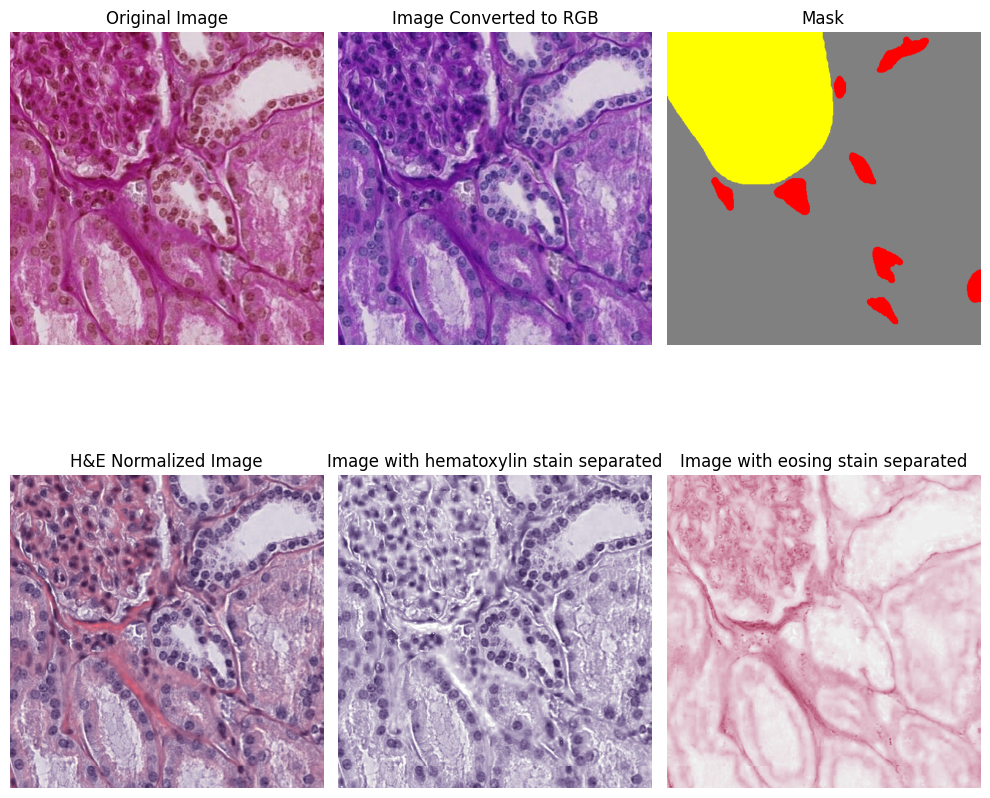

In [66]:
plt.figure(figsize=(10,10))
for idx in range(len(image_titles)):
  plt.subplot(2,3,idx+1)
  plt.imshow(images[idx])
  plt.title(image_titles[idx])
  plt.axis('off')
plt.tight_layout()

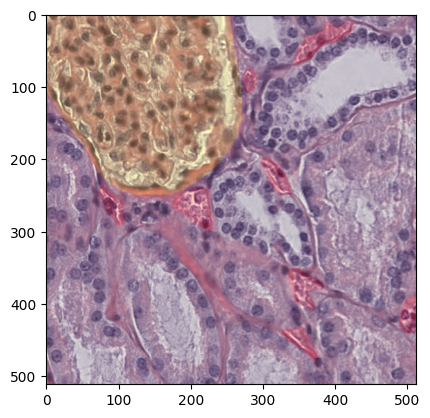

In [65]:
# Overlay image with mask
plt.imshow(Inorm)
plt.imshow(mask,alpha=0.2);